In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import join
import shutil
import sys
import xarray as xr

# local functions
sys.path.append('support_funcs')
from XB_func import plot_vals, to_pickle, from_pickle, plot_transect, check_dir, create_xb_dirs, write_xb_hydrodynamics, XBwriteveg


## Shore normal transects

Transect are provided

   dist_total  elevation  vegetation
0         0.0     -2.955          -1
1        10.0     -2.955          -1
2        20.0     -2.955          -1
3        30.0     -3.040          -1
4        40.0     -3.040          -1


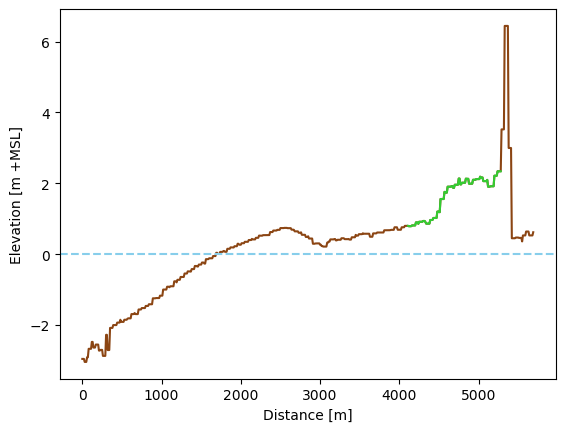

In [2]:
#1 Inspect the transects

# load a transect
selected_transect_nr  = 3 # value [1,2,3]
df_transect           = from_pickle('01_transects/transect_'  + str(int(selected_transect_nr)) +  '.pkl')

# check the content of the DataFrame
print(df_transect.head())

# plot a transect.
plot_transect(df_transect = df_transect)


## XBeach simulations

### Input

In [3]:
# 2.1 Create simulation folder

# - This functionality loads data and writes XBbeach input data to a destination folder

# First, we create a directory to store the input files for the simulation.
simulation_number = 1
sim_name          = '_test'
# creating the directory
sim_dir           = '02_XB_sims/sim' + "{:02d}".format(simulation_number) + sim_name

dirs = create_xb_dirs(sim_dir) 


Directory [02_XB_sims/sim01_test/veg] is created
Directory [02_XB_sims/sim01_test/noveg] is created


In [4]:
# 2.2 Provide (a) hydrodynamic input conditions and (b) vegetation input conditions and create input files

"""
Parameters:
------------

Hydrodynamics:
    zs0: Float
        design storm water level in meters (vertical reference frame according to the elevation column in df_transect)
    Hm0: Float
        significant wave height [m] (enforced as boundary condition at the start of the transect)
    fp: Float
        peak frequency (= 1 / peak period)

Vegetation:
    nveg: Integer
        Vegetation density [stems/m2]
    dveg: Float
        Representative vegetation stem diameter [m]
    hveg: Float
        Vegetation height [m]
    Cd: Float
        Bulk drag coefficient [-]

Change the fields in the block below with your own values (the given values are dummy values). 
        
"""
# ===============================================
# ===============================================
# ========== USER INPUT =========================
# ===============================================

# select transect (1,2 or 3)
transect_nr = 1 

# hydrodynamic input
zs0         = 1          # design storm water level in meters (vertical reference frame wrt elevation column in df_transect)
Hm0         = 1          # significant wave height
fp          = 1/2        # peak frequency (= 1 / Tp)


# vegetation input
name_v  = 'saltmarsh1'            # vegetation name (for your own administration) 
hv      = 1.0                     # vegetation height  [m]
bv      = 0.005                   # representative diameter [m]
nv      = 10                      # vegetation density [1/m2]
cd      = 0.5                     # drag coeficient [-]


# ===============================================
# ======= no changes required below ============= 
# ===============================================
# ===============================================

df_transect = from_pickle('01_transects/transect_'  + str(int(transect_nr)) +  '.pkl')
#     Write XBeach input files
d_veg   = {'name_v':name_v, 'hv':hv, 'bv':bv,'nv':nv,'cd':cd}
d_noveg =  {'name_v':'noveg', 'hv':0, 'bv':0,'nv':0,'cd':0}
for wd_sel in dirs:
    print('  - Start to write input to: [' + wd_sel + ']')
    # grid and bathymetry
    xgrid  = df_transect.dist_total.values; np.savetxt(join(wd_sel,'xgrid.grd'), xgrid)
    dep    = df_transect.elevation.values; np.savetxt(join(wd_sel,'bed.dep'), dep)

    # hydrodynamics
    xb_template_dir = '02_XB_sims/00_dummy_xbinput_files'
    write_xb_hydrodynamics(xgrid, xb_template_dir, wd_sel, zs0, Hm0, fp)

    # Vegetation in XBeach 
    #    The XBeach vegetation module requires different veg input (files):    
    #        1. the veggiemap file -> indicates where vegetation is present in the computational domain(0 = no veg, 1 = vegtype1, 2 = vegtype2, ..n)
    #        2. the veggie file    -> indicates where WHAT type of vegetation is present by providing the vegtype.txt files that corresponds to the integers provided in the veggiepatch file. 
    #        3. the vegtypes file(s) -> indicate the vegetation schematization. (nsec = vertical layer nr, N = density, d = representative diamter, h = height, Cd = drag coef.)
    #        4. 'vegetation' = 1 keyword in the params file (set vegetation = 0 to turn off the vegetation module)
    #
    #     For detailed information visit: https://xbeach.readthedocs.io/en/latest/xbeach_manual.html#vegetation-input
    if wd_sel.split('/')[-1] == 'veg':
        df_transect.loc[df_transect.vegetation == -1,'vegetation'] = 0
        np.savetxt(join(wd_sel,'vegpatch.txt'), df_transect.vegetation.values)
        XBwriteveg(wd_sel, d_veg)
    elif wd_sel.split('/')[-1] == 'noveg':
        df_transect['noveg'] = 0
        np.savetxt(join(wd_sel,'vegpatch.txt'), df_transect.noveg.values)
        XBwriteveg(wd_sel, d_noveg)

    # copy bat file to simulation folder
    shutil.copyfile('02_XB_sims/00_dummy_input_xbfiles/run_xb.bat',join(wd_sel,'run_xb.bat'))            
print('Finished writing XB input')
 
# zip, so you are able to download the entire simulation folder to your own computer. 
fn_zip = sim_dir
shutil.make_archive(fn_zip,'zip',sim_dir)     
print('Simulation folders are zipped to ' + fn_zip  + '.zip')        



  - Start to write input to: [02_XB_sims/sim01_test/veg]


<class 'FileNotFoundError'>: [Errno 44] No such file or directory: '02_XB_sims/00_dummy_input_files/paramssb_0.txt'

### Run XBeach

XBeach is a two-dimensional model for wave propagation, long waves and mean flow, sediment transport and morphological change on the coastal nearshore area (Roelvink et al., 2009). 
It includes a vegetation module that solves short-wave and long-wave -vegetation interaction (Van Rooijen et al., 2015; Van Rooijen et al., 2016).

You will run the XBeach simulations on your device: 
    
    1) download the *.zip-file
    2) unpack the file in the [02_XB_sims/] folder
    3) run the simulation in the folder by activating [run_xb.bat] (by clicking)

Note: if the XBeach software is not stored in the right directory (should be 00_XB_software) the simulation cannot be started using the provided *.bat-file






In [ ]:
# 4 Visualize output